# Hazelnut defect dataset EDA (MVTec AD)

This notebook explores the first dataset located at `data/hazelnut_1` to understand
its structure, class balance, image properties, and defect masks.

## TLDR

There's a lot of EDA done here (as will be for any other datasets I can scour), so here's the TLDR:
* The dataset is fairly simple. It's got `400` or so "Good" images, then ~`100` "Bad" images, each of which have a segmentation mask image that can be overlayed. It also categorizes the defect types (which we don't cre too much about)
* More useful in MVP work: The images are all fairly high-quality and have perfect black backgrounds, with a single nut in each image.
* Value in analysis: lots of potential defect types, likely path forward will involve quite a lot of segmentation.
* This dataset is quite small and doesn't capture great variance for generalization. A simple logistic regression model (without messing with any hyperparameters) can achieve a perfect f-1 score (classifies both good and bad hazelnuts perfectly).

In [44]:
from pathlib import Path
import random
import os
import tarfile
import urllib.request
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# Default random seed to 42, should be set in environment
SEED: int = int(os.getenv("SEED", "42"))
random.seed(SEED)
np.random.seed(SEED)

# Auto-download MVTec AD if missing
DATA_DIR = Path("data/hazelnut_1")
ALT_DIR = Path("data/mvtec_anomaly_detection/hazelnut")
ARCHIVE_PATH = Path("data/mvtec_anomaly_detection.tar.xz")
MVTEC_AD_URL = (
    "https://www.mydrive.ch/shares/38536/"
    "3830184030e49fe74747669442f0f282/"
    "download/420938113-1629952094/"
    "mvtec_anomaly_detection.tar.xz"
)

def download_mvtec_ad(url=MVTEC_AD_URL, dest=ARCHIVE_PATH):
    dest.parent.mkdir(parents=True, exist_ok=True)
    if dest.exists():
        print(f"Archive exists: {dest}")
        return dest

    print("Downloading MVTec AD archive...")
    with urllib.request.urlopen(url) as resp:
        total = int(resp.headers.get("Content-Length", 0))
        with open(dest, "wb") as f:
            if total > 0:
                with tqdm(total=total, unit="B", unit_scale=True, desc="download") as pbar:
                    while True:
                        chunk = resp.read(1024 * 1024)
                        if not chunk:
                            break
                        f.write(chunk)
                        pbar.update(len(chunk))
            else:
                shutil.copyfileobj(resp, f)
    return dest


def extract_mvtec_ad(archive=ARCHIVE_PATH, dest=Path("data")):
    print(f"Extracting {archive} to {dest}")
    with tarfile.open(archive, "r:xz") as tar:
        tar.extractall(dest)


def resolve_data_dir():
    if DATA_DIR.exists():
        return DATA_DIR
    if ALT_DIR.exists():
        return ALT_DIR

    try:
        archive = download_mvtec_ad()
        extract_mvtec_ad(archive, Path("data"))
    except Exception as e:
        raise RuntimeError(
            "Auto-download failed. Download the dataset from the official MVTec AD page "
            "and place the 'hazelnut' folder under data/mvtec_anomaly_detection/ or copy "
            "it to data/hazelnut_1."
        ) from e

    if ALT_DIR.exists():
        return ALT_DIR
    if DATA_DIR.exists():
        return DATA_DIR

    raise FileNotFoundError("Could not find hazelnut dataset after download/extract.")

DATA_DIR = resolve_data_dir()
print(f"Using dataset: {DATA_DIR}")

pd.set_option("display.max_rows", 200)
plt.rcParams["figure.figsize"] = (10, 5)


In [45]:
train_dir = DATA_DIR / "train"
test_dir = DATA_DIR / "test"
mask_dir = DATA_DIR / "ground_truth"

exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def list_images(d: Path):
    return sorted([p for p in d.iterdir() if p.is_file() and p.suffix.lower() in exts])

train_good = list_images(train_dir / "good")

test_classes = sorted([p.name for p in test_dir.iterdir() if p.is_dir()])
mask_classes = sorted([p.name for p in mask_dir.iterdir() if p.is_dir()])

print("Train good images:", len(train_good))
print("Test classes:", test_classes)
print("Mask classes:", mask_classes)

Train good images: 391
Test classes: ['crack', 'cut', 'good', 'hole', 'print']
Mask classes: ['crack', 'cut', 'hole', 'print']


In [46]:
rows = []
rows.append({"split": "train", "class": "good", "count": len(train_good)})

for cls in test_classes:
    files = list_images(test_dir / cls)
    rows.append({"split": "test", "class": cls, "count": len(files)})

counts_df = pd.DataFrame(rows).sort_values(["split", "class"]).reset_index(drop=True)
counts_df

split  class  count
0   test  crack     18
1   test    cut     17
2   test   good     40
3   test   hole     18
4   test  print     17
5  train   good    391

In [47]:
# Collect all image files for inspection
all_images = []
for p in train_good:
    all_images.append(("train", "good", p))

for cls in test_classes:
    for p in list_images(test_dir / cls):
        all_images.append(("test", cls, p))

len(all_images)

501

In [48]:
# Image size, mode, and basic integrity checks
records = []
errors = []

for split, cls, p in tqdm(all_images):
    try:
        with Image.open(p) as img:
            w, h = img.size
            mode = img.mode
        records.append({
            "split": split,
            "class": cls,
            "path": str(p),
            "width": w,
            "height": h,
            "mode": mode,
        })
    except Exception as e:
        errors.append((str(p), repr(e)))

img_df = pd.DataFrame(records)
print("Unreadable images:", len(errors))
img_df.head()

100%|██████████| 501/501 [00:00<00:00, 5227.83it/s]

Unreadable images: 0


split class                                path  width  height mode
0  train  good  data/hazelnut_1/train/good/000.png   1024    1024  RGB
1  train  good  data/hazelnut_1/train/good/001.png   1024    1024  RGB
2  train  good  data/hazelnut_1/train/good/002.png   1024    1024  RGB
3  train  good  data/hazelnut_1/train/good/003.png   1024    1024  RGB
4  train  good  data/hazelnut_1/train/good/004.png   1024    1024  RGB

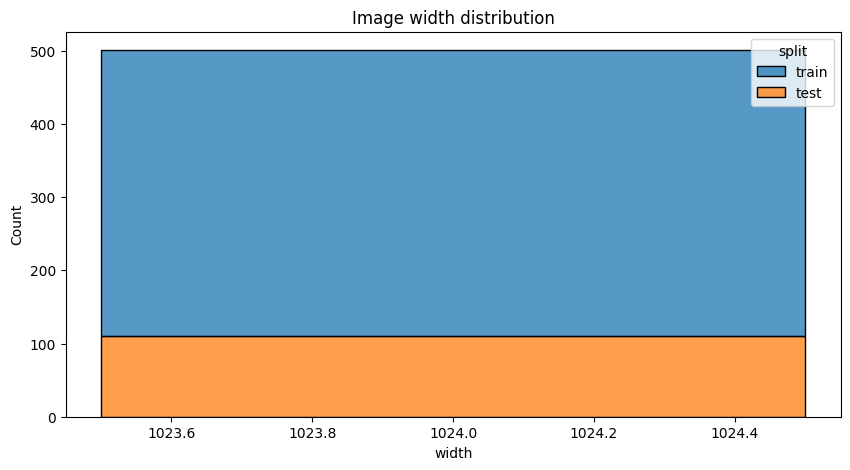

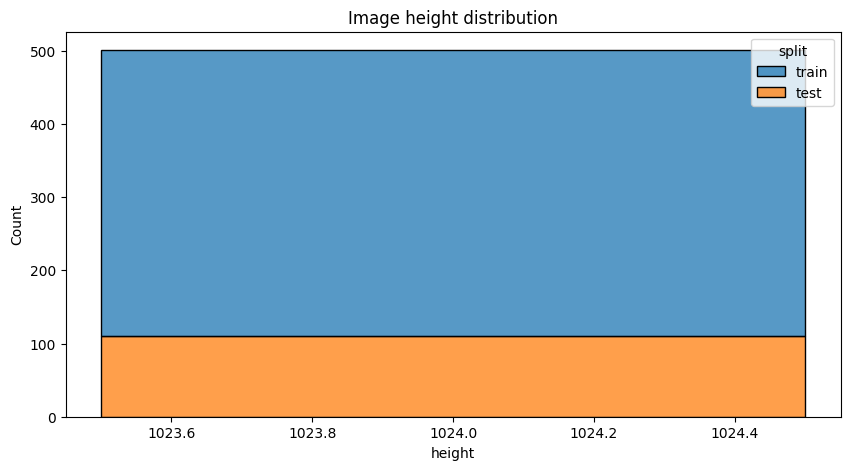

split  class mode  count
0   test  crack  RGB     18
1   test    cut  RGB     17
2   test   good  RGB     40
3   test   hole  RGB     18
4   test  print  RGB     17
5  train   good  RGB    391

In [49]:
# Image size distribution
sns.histplot(img_df, x="width", hue="split", multiple="stack")
plt.title("Image width distribution")
plt.show()

sns.histplot(img_df, x="height", hue="split", multiple="stack")
plt.title("Image height distribution")
plt.show()

img_df.groupby(["split", "class", "mode"]).size().reset_index(name="count")

In [50]:
# Sample mean/std stats on train-good (RGB)

# 	channel	mean	std
# 0	R	0.241144	0.165189
# 1	G	0.177823	0.073087
# 2	B	0.172179	0.041585

# This cell can take a little, it'll output the above distribution. Save some time unless you really wanna run it.
SAMPLE_RGB_DISTRIBUTION: bool = False


def sample_files(files, n=200):
    if len(files) <= n:
        return files
    return random.sample(files, n)

if SAMPLE_RGB_DISTRIBUTION is True:
    sample = sample_files(train_good, n=200)

    means = []
    stds = []
    for p in tqdm(sample):
        with Image.open(p) as img:
            img = img.convert("RGB")
            arr = np.asarray(img, dtype=np.float32) / 255.0
        means.append(arr.mean(axis=(0, 1)))
        stds.append(arr.std(axis=(0, 1)))

    means = np.vstack(means)
    stds = np.vstack(stds)

    stats = pd.DataFrame({
        "channel": ["R", "G", "B"],
        "mean": means.mean(axis=0),
        "std": stds.mean(axis=0),
    })
    stats

In [51]:
# Ground-truth mask coverage and alignment with test images

def mask_coverage_for_class(cls):
    test_files = list_images(test_dir / cls)
    mask_files = list_images(mask_dir / cls)

    test_stems = {p.stem for p in test_files}
    mask_stems = {p.stem.replace("_mask", "") for p in mask_files}

    missing_masks = sorted(test_stems - mask_stems)
    orphan_masks = sorted(mask_stems - test_stems)

    coverages = []
    for p in mask_files:
        with Image.open(p) as img:
            mask = np.asarray(img.convert("L"))
        coverages.append((mask > 0).mean())

    return {
        "class": cls,
        "test_count": len(test_files),
        "mask_count": len(mask_files),
        "missing_masks": len(missing_masks),
        "orphan_masks": len(orphan_masks),
        "coverage_mean": float(np.mean(coverages)) if coverages else 0.0,
        "coverage_median": float(np.median(coverages)) if coverages else 0.0,
        "coverage_min": float(np.min(coverages)) if coverages else 0.0,
        "coverage_max": float(np.max(coverages)) if coverages else 0.0,
    }

mask_stats = [mask_coverage_for_class(cls) for cls in mask_classes]
mask_df = pd.DataFrame(mask_stats)
mask_df

class  test_count  mask_count  missing_masks  orphan_masks  coverage_mean  \
0  crack          18          18              0             0       0.084009   
1    cut          17          17              0             0       0.008768   
2   hole          18          18              0             0       0.013336   
3  print          17          17              0             0       0.026293   

   coverage_median  coverage_min  coverage_max  
0         0.047003      0.012812      0.276586  
1         0.007860      0.003975      0.020165  
2         0.012364      0.002329      0.029346  
3         0.024358      0.015165      0.048274

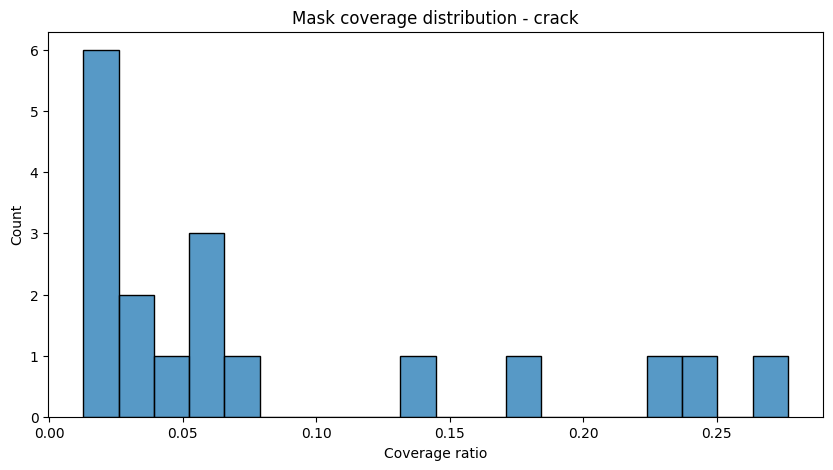

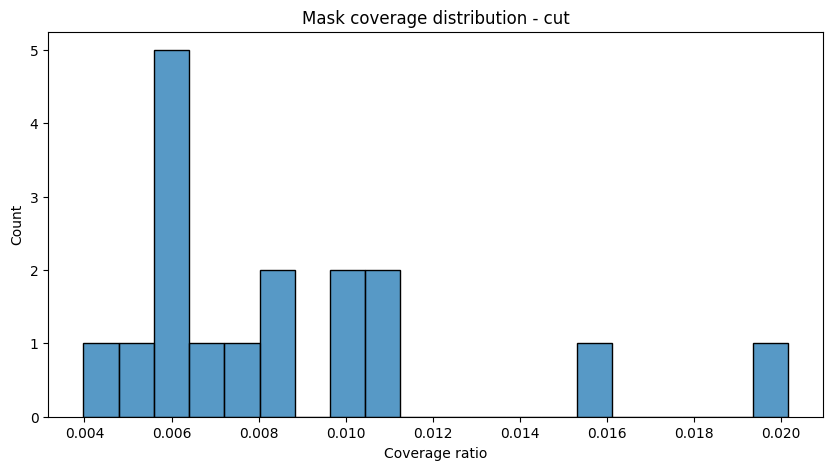

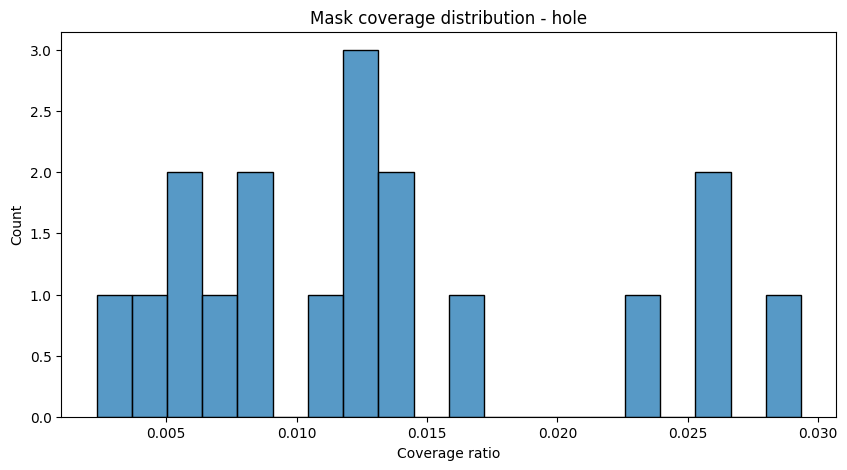

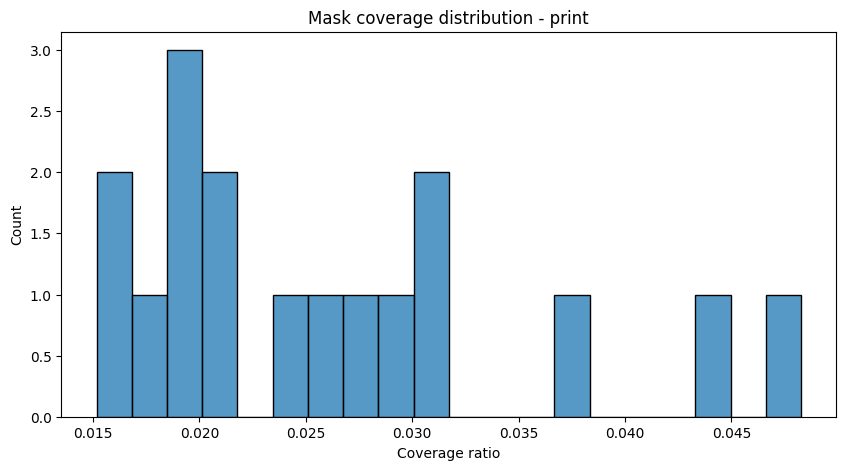

In [52]:
# Coverage distributions by defect class
for cls in mask_classes:
    mask_files = list_images(mask_dir / cls)
    coverages = []
    for p in mask_files:
        with Image.open(p) as img:
            mask = np.asarray(img.convert("L"))
        coverages.append((mask > 0).mean())

    if coverages:
        sns.histplot(coverages, bins=20)
        plt.title(f"Mask coverage distribution - {cls}")
        plt.xlabel("Coverage ratio")
        plt.show()

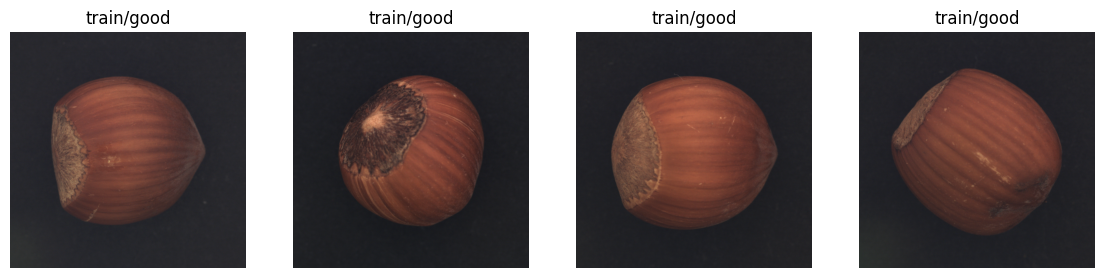

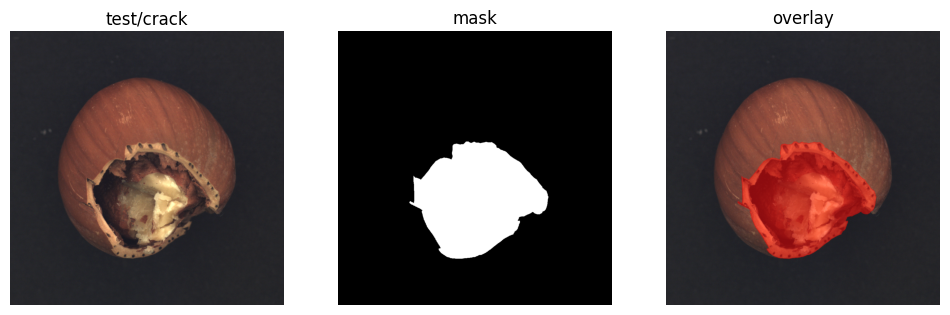

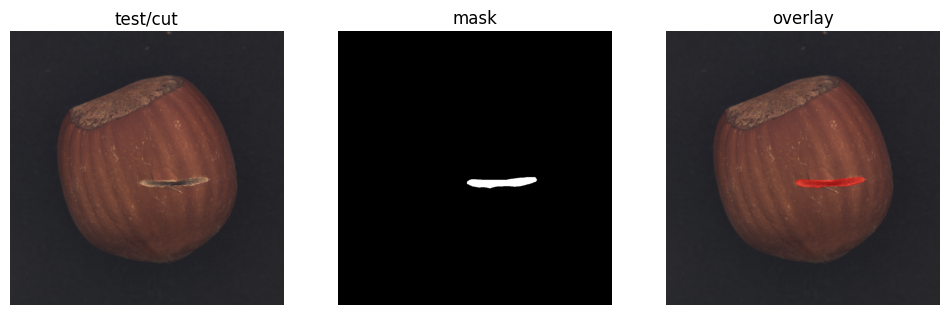

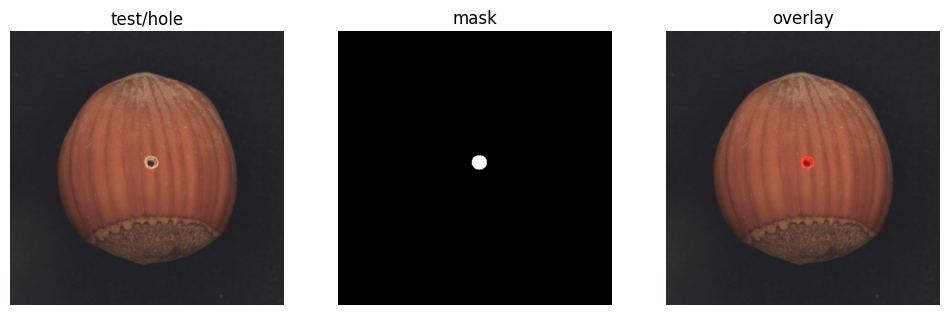

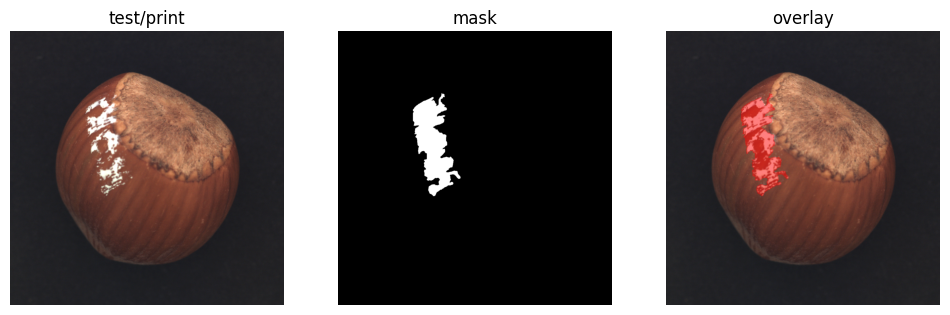

In [53]:
# Visual samples

def overlay_mask(img, mask, color=(255, 0, 0), alpha=0.5):
    img = img.convert("RGB")
    mask = mask.convert("L")
    arr = np.asarray(img).copy()
    m = np.asarray(mask) > 0
    arr[m] = (1 - alpha) * arr[m] + alpha * np.array(color)
    return arr.astype(np.uint8)

# Good samples
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
for ax, p in zip(axes, random.sample(train_good, k=min(4, len(train_good)))):
    ax.imshow(Image.open(p))
    ax.set_title("train/good")
    ax.axis("off")
plt.show()

# Defect samples with masks
for cls in mask_classes:
    test_files = list_images(test_dir / cls)
    mask_files = list_images(mask_dir / cls)
    if not test_files or not mask_files:
        continue

    p = random.choice(test_files)
    mask_path = mask_dir / cls / f"{p.stem}_mask.png"
    if not mask_path.exists():
        continue

    img = Image.open(p)
    mask = Image.open(mask_path)
    overlay = overlay_mask(img, mask)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img)
    axes[0].set_title(f"test/{cls}")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("mask")
    axes[1].axis("off")
    axes[2].imshow(overlay)
    axes[2].set_title("overlay")
    axes[2].axis("off")
    plt.show()

## Deeper dives

Additional analysis to surface structure, intensity/texture signals, and mask behavior.

With this dataset and the class distribution it would end up being more of an anomaly detection case (~`20%` of the target variable is defect)

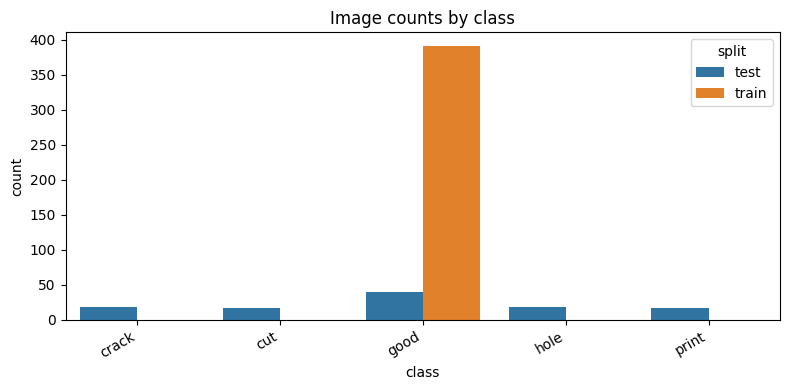

In [54]:
# Count plot for class balance
plt.figure(figsize=(8, 4))
sns.barplot(data=counts_df, x="class", y="count", hue="split")
plt.title("Image counts by class")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [55]:
# Per-class image size summary
size_summary = (
    img_df.groupby(["split", "class", "width", "height"]).size()
    .reset_index(name="count")
    .sort_values(["split", "class", "count"], ascending=[True, True, False])
)

size_summary.head(10)

split  class  width  height  count
0   test  crack   1024    1024     18
1   test    cut   1024    1024     17
2   test   good   1024    1024     40
3   test   hole   1024    1024     18
4   test  print   1024    1024     17
5  train   good   1024    1024    391

In [56]:
# Per-image intensity/texture stats (sampled)

def image_stats(p):
    with Image.open(p) as img:
        img = img.convert("L")
        arr = np.asarray(img, dtype=np.float32) / 255.0
    mean = float(arr.mean())
    std = float(arr.std())
    gy, gx = np.gradient(arr)
    grad = float(np.sqrt(gx ** 2 + gy ** 2).mean())
    return mean, std, grad


def sample_files(files, n=200):
    if len(files) <= n:
        return files
    return random.sample(files, n)

stat_rows = []

# Train good
for p in tqdm(sample_files(train_good, n=200), desc="train/good stats"):
    mean, std, grad = image_stats(p)
    stat_rows.append({"split": "train", "class": "good", "mean": mean, "std": std, "grad": grad})

# Test classes
for cls in test_classes:
    files = list_images(test_dir / cls)
    for p in tqdm(sample_files(files, n=200), desc=f"test/{cls} stats"):
        mean, std, grad = image_stats(p)
        stat_rows.append({"split": "test", "class": cls, "mean": mean, "std": std, "grad": grad})

stats_df = pd.DataFrame(stat_rows)
stats_df.tail()

test/print stats: 100%|██████████| 17/17 [00:01<00:00, 10.97it/s]


split  class      mean       std      grad
305  test  print  0.202342  0.118296  0.006467
306  test  print  0.204004  0.105529  0.005962
307  test  print  0.209057  0.122639  0.006715
308  test  print  0.199481  0.092363  0.005875
309  test  print  0.211595  0.136829  0.007469

In [57]:
# Summary table of intensity/texture metrics
stats_summary = (
    stats_df.groupby(["split", "class"])
    .agg(
        mean_mean=("mean", "mean"),
        mean_std=("mean", "std"),
        std_mean=("std", "mean"),
        std_std=("std", "std"),
        grad_mean=("grad", "mean"),
        grad_std=("grad", "std"),
        n=("mean", "size"),
    )
    .reset_index()
)

stats_summary.sort_values(["split", "class"]).reset_index(drop=True)

split  class  mean_mean  mean_std  std_mean   std_std  grad_mean  grad_std  \
0   test  crack   0.206973  0.008552  0.097302  0.017421   0.006615  0.001044   
1   test    cut   0.210323  0.008317  0.090559  0.008649   0.005759  0.000267   
2   test   good   0.213582  0.007449  0.089245  0.009096   0.005667  0.000416   
3   test   hole   0.204239  0.006983  0.090814  0.008085   0.006129  0.000334   
4   test  print   0.202444  0.013798  0.122892  0.017396   0.006480  0.000647   
5  train   good   0.194572  0.015146  0.094684  0.019238   0.005542  0.000559   

     n  
0   18  
1   17  
2   40  
3   18  
4   17  
5  200

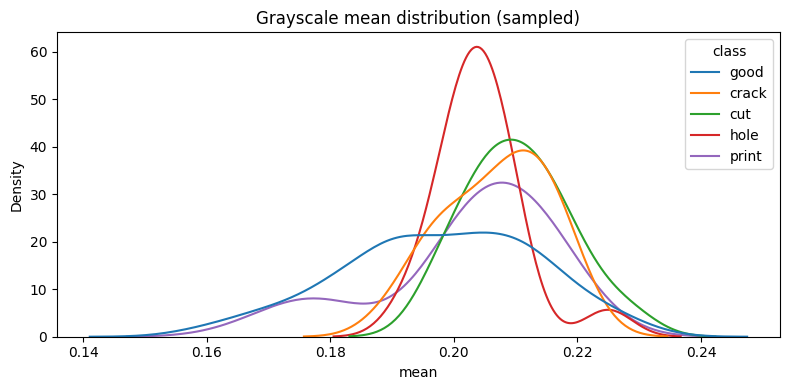

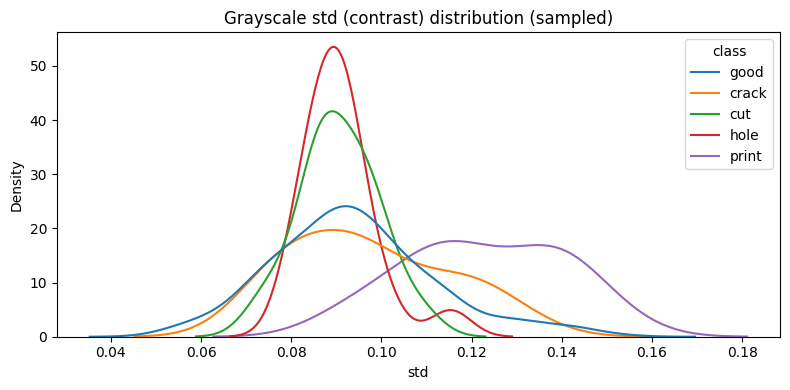

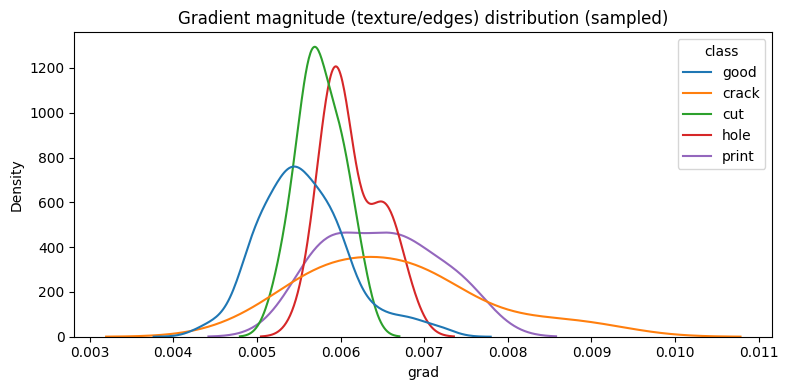

In [58]:
# Visualize distributions for good vs defects
plt.figure(figsize=(8, 4))
sns.kdeplot(data=stats_df, x="mean", hue="class", common_norm=False)
plt.title("Grayscale mean distribution (sampled)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.kdeplot(data=stats_df, x="std", hue="class", common_norm=False)
plt.title("Grayscale std (contrast) distribution (sampled)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.kdeplot(data=stats_df, x="grad", hue="class", common_norm=False)
plt.title("Gradient magnitude (texture/edges) distribution (sampled)")
plt.tight_layout()
plt.show()

We see a wider variance in cracks, followed by prints, holes, and cuts being pretty small coverage, at least in this dataset.

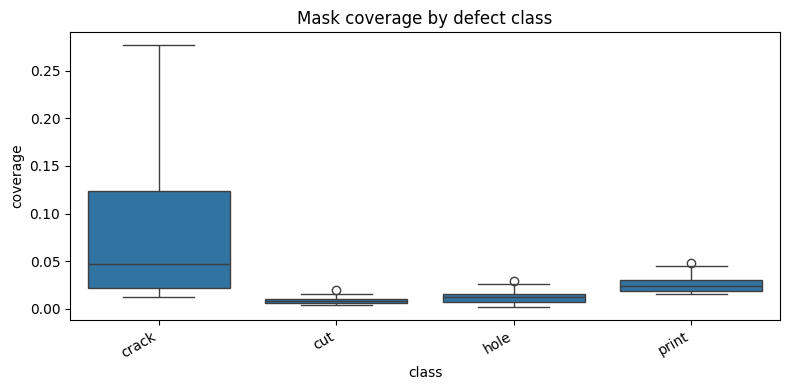

In [59]:
# Mask coverage distributions by defect class (boxplot)
mask_cov_rows = []
for cls in mask_classes:
    mask_files = list_images(mask_dir / cls)
    for p in mask_files:
        with Image.open(p) as img:
            mask = np.asarray(img.convert("L"))
        mask_cov_rows.append({"class": cls, "coverage": (mask > 0).mean()})

mask_cov_df = pd.DataFrame(mask_cov_rows)

plt.figure(figsize=(8, 4))
sns.boxplot(data=mask_cov_df, x="class", y="coverage")
plt.title("Mask coverage by defect class")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

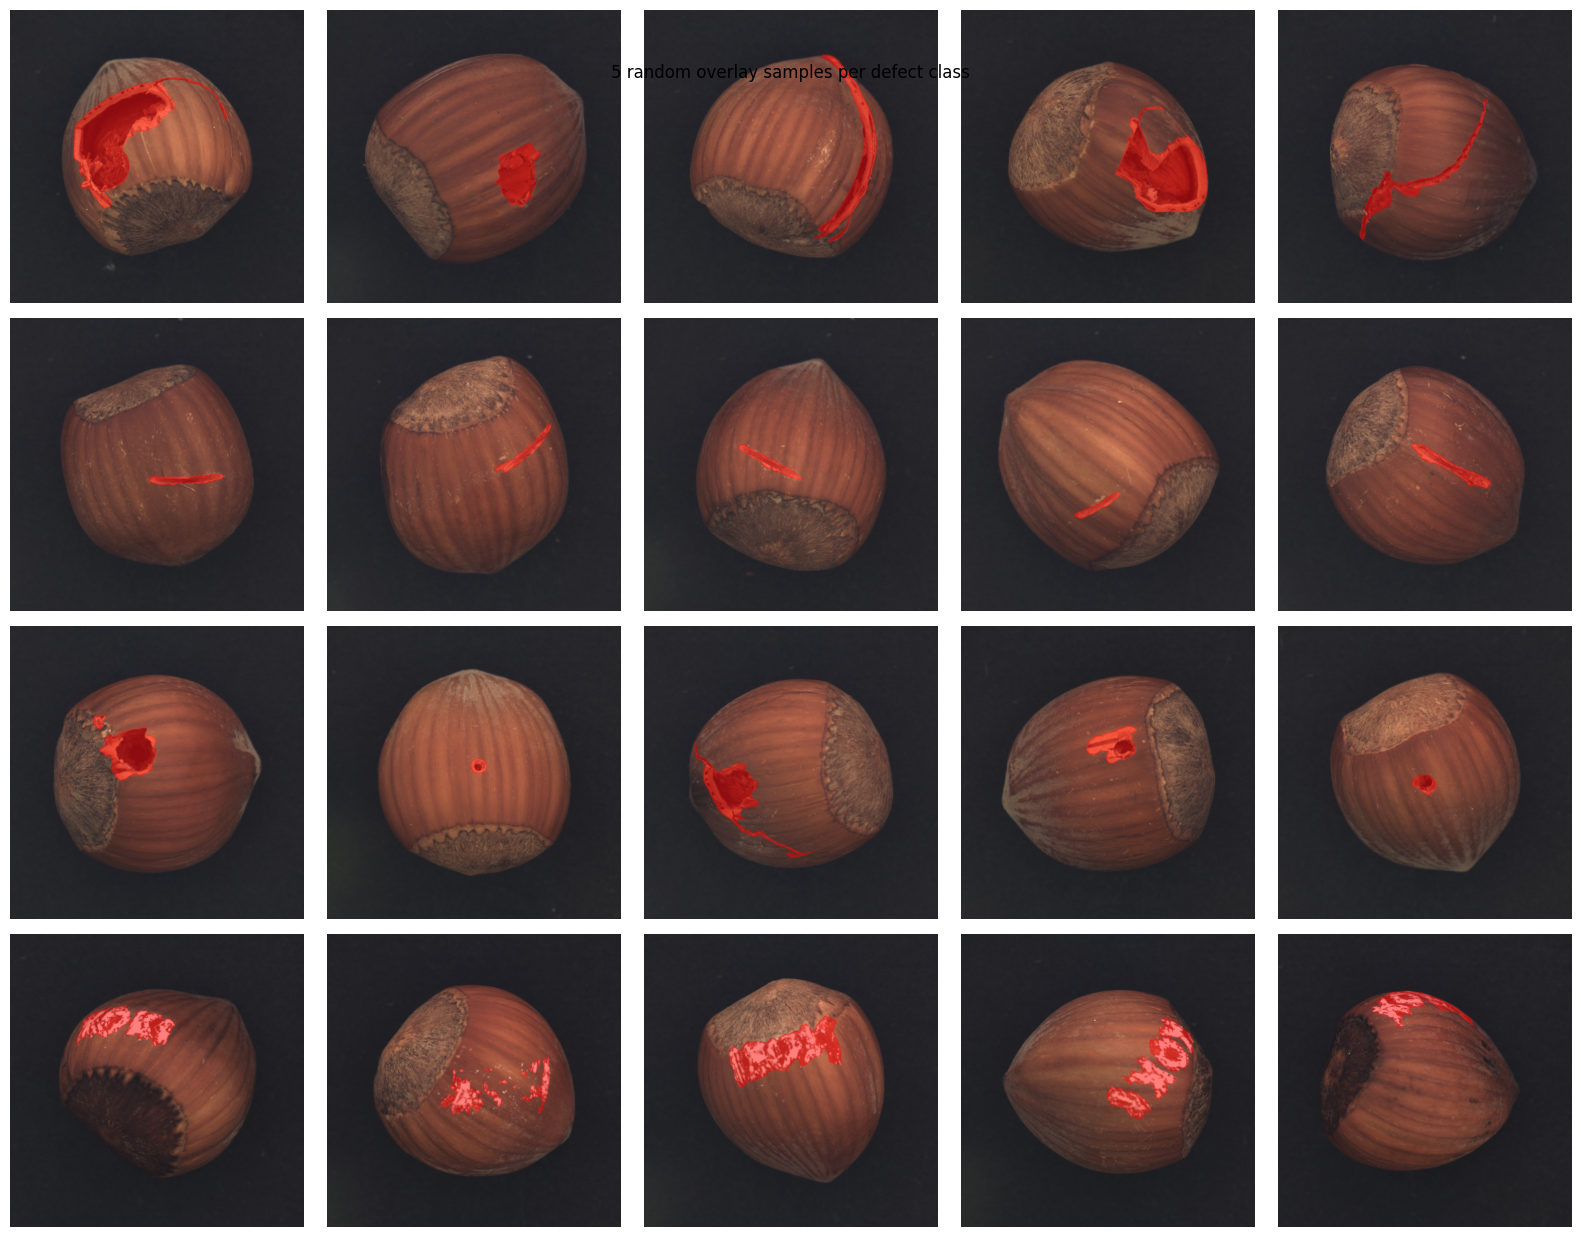

In [ ]:
# Large grid of overlays: 5 random samples per defect class
n_per_class = 5
classes = mask_classes

fig, axes = plt.subplots(len(classes), n_per_class, figsize=(n_per_class * 3.2, len(classes) * 3.2))
if len(classes) == 1:
    axes = np.array([axes])

for i, cls in enumerate(classes):
    test_files = list_images(test_dir / cls)
    test_files = [p for p in test_files if (mask_dir / cls / f"{p.stem}_mask.png").exists()]

    if test_files:
        samples = random.sample(test_files, k=min(n_per_class, len(test_files)))
    else:
        samples = []

    # pad to keep layout stable
    while len(samples) < n_per_class:
        samples.append(None)

    for j, p in enumerate(samples):
        ax = axes[i, j]
        if p is None:
            ax.axis("off")
            continue
        mask_path = mask_dir / cls / f"{p.stem}_mask.png"
        img = Image.open(p)
        mask = Image.open(mask_path)
        overlay = overlay_mask(img, mask, alpha=0.5)
        ax.imshow(overlay)
        ax.axis("off")

    axes[i, 0].set_ylabel(cls, rotation=0, labelpad=30, fontsize=10)

plt.suptitle("5 random overlay samples per defect class", y=0.92)
plt.tight_layout()
plt.show()

## SSIM + feature-space separability

This section uses SSIM to compare visual similarity, and simple downsampled
features to evaluate separability across classes.

In [71]:
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score, f1_score

In [62]:
# SSIM analysis

def load_gray(p, size=(256, 256)):
    img = Image.open(p).convert("L")
    if size is not None:
        img = img.resize(size, Image.BILINEAR)
    return np.asarray(img)


def ssim_pairs(files_a, files_b=None, n_pairs=50, size=(256, 256)):
    scores = []
    if files_b is None:
        if len(files_a) < 2:
            return scores
        for _ in range(n_pairs):
            p1, p2 = random.sample(files_a, 2)
            i1 = load_gray(p1, size)
            i2 = load_gray(p2, size)
            scores.append(ssim(i1, i2))
    else:
        if not files_a or not files_b:
            return scores
        for _ in range(n_pairs):
            p1 = random.choice(files_a)
            p2 = random.choice(files_b)
            i1 = load_gray(p1, size)
            i2 = load_gray(p2, size)
            scores.append(ssim(i1, i2))
    return scores

# Use test set for SSIM comparisons
ssim_rows = []

test_good = list_images(test_dir / "good")

# Good-good
for v in ssim_pairs(test_good, None, n_pairs=80):
    ssim_rows.append({"pair": "good-good", "ssim": v})

# Defect-defect (per class)
for cls in [c for c in test_classes if c != "good"]:
    files = list_images(test_dir / cls)
    for v in ssim_pairs(files, None, n_pairs=80):
        ssim_rows.append({"pair": f"{cls}-{cls}", "ssim": v})

# Good-defect
for cls in [c for c in test_classes if c != "good"]:
    files = list_images(test_dir / cls)
    for v in ssim_pairs(test_good, files, n_pairs=80):
        ssim_rows.append({"pair": f"good-{cls}", "ssim": v})

ssim_df = pd.DataFrame(ssim_rows)
ssim_df.head()

pair      ssim
0  good-good  0.782788
1  good-good  0.819475
2  good-good  0.800555
3  good-good  0.832120
4  good-good  0.796555

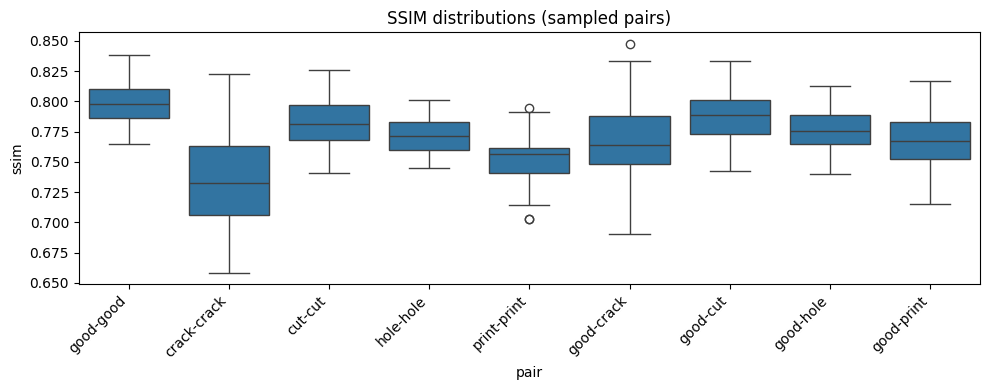

In [63]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=ssim_df, x="pair", y="ssim")
plt.title("SSIM distributions (sampled pairs)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# Feature-space separability using simple downsampled grayscale features

def featurize(p, size=(64, 64)):
    img = Image.open(p).convert("L")
    img = img.resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr.flatten()

n_per_class = 200
rows = []

for cls in test_classes:
    files = list_images(test_dir / cls)
    if len(files) > n_per_class:
        files = random.sample(files, n_per_class)

    for p in files:
        rows.append({"class": cls, "path": str(p)})

sample_df = pd.DataFrame(rows)

features = []
labels = []
for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="featurize"):
    features.append(featurize(Path(row["path"])))
    labels.append(row["class"])

X = np.vstack(features)
y = np.array(labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=SEED)
X_2d = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({"pc1": X_2d[:, 0], "pc2": X_2d[:, 1], "class": y})

featurize: 100%|██████████| 110/110 [00:10<00:00, 10.48it/s]


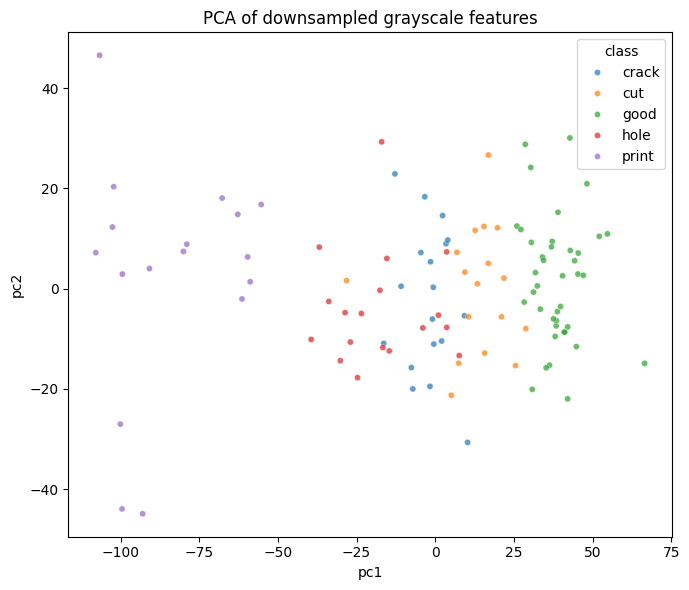

In [65]:
plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x="pc1", y="pc2", hue="class", alpha=0.7, s=20)
plt.title("PCA of downsampled grayscale features")
plt.tight_layout()
plt.show()

A simple logistic regression model can perform with a perfect f1 score on the target and "good" class. No Neural Networks even needed

In [ ]:
# Separability metrics

# Multi-class logistic regression
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=SEED, stratify=y
)

clf = LogisticRegression(max_iter=1000) # Defaults to multi_class = auto
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print("Multiclass accuracy:", round(acc, 4))

# Binary (good vs defect)
bin_y = (y != "good").astype(int)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_scaled, bin_y, test_size=0.3, random_state=SEED, stratify=bin_y
)

clf_b = LogisticRegression(max_iter=1000)
clf_b.fit(X_train_b, y_train_b)

pred_b = clf_b.predict(X_test_b)
acc_b = accuracy_score(y_test_b, pred_b)
f1_b = f1_score(y_test_b, pred_b)
print("Binary accuracy (good vs defect):", round(acc_b, 4))
print("Binary Classification F1 Score:", f1_b)

# Silhouette score on PCA space (rough separability indicator)
sil = silhouette_score(X_2d, y)
print("Silhouette score (PCA 2D):", round(sil, 4))

Multiclass accuracy: 0.7576
Binary accuracy (good vs defect): 1.0
Binary Classification F1 Score: 1.0
Silhouette score (PCA 2D): 0.2583


Not quite as good if you want to specifically figure out the defect type (misclassifies holes and cracks, cuts as cracks, even misclassifies a cut as good!)

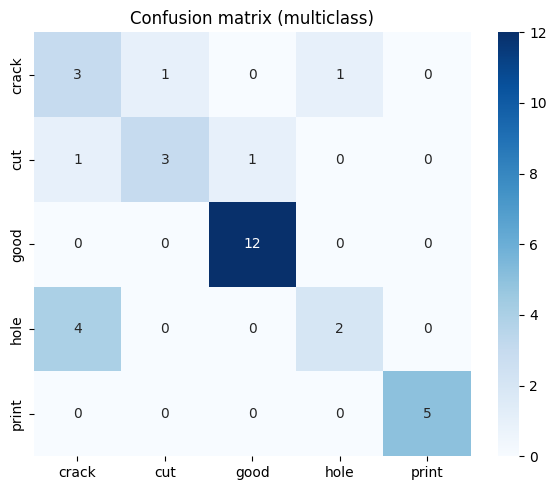

In [70]:
# Confusion matrix for multiclass classifier
cm = confusion_matrix(y_test, pred, labels=sorted(test_classes))
cm_df = pd.DataFrame(cm, index=sorted(test_classes), columns=sorted(test_classes))

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix (multiclass)")
plt.tight_layout()
plt.show()